In [4]:
import pandas as pd
import numpy as np
#from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
path = '/datasets/'

In [5]:
# Загружаем датасет и выводим выборочно 2 строк
cars_df = pd.read_csv(path + '/cars_new.csv')
cars_df.sample(5)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
18290,opel,astra j,489000,2010,73800,хетчбэк,автомат,бензин,1.6,115.0
43257,mercedes-benz,m-класс 350 w166,2125000,2015,90521,кроссовер,автомат,дизель,3.0,258.0
65201,honda,cr-v 4 поколение,1097000,2013,215100,кроссовер,автомат,бензин,2.0,150.0
34162,skoda,yeti 1 поколение [рестайлинг],929000,2017,36395,кроссовер,автомат,бензин,1.6,110.0
25293,peugeot,308 sw t7,300000,2009,150000,универсал,автомат,бензин,1.6,120.0


In [6]:
# информация о датасете
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70119 entries, 0 to 70118
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mark     70119 non-null  object 
 1   model    70119 non-null  object 
 2   price    70119 non-null  int64  
 3   year     70119 non-null  int64  
 4   mileage  70119 non-null  int64  
 5   body     70116 non-null  object 
 6   kpp      70115 non-null  object 
 7   fuel     70119 non-null  object 
 8   volume   70119 non-null  float64
 9   power    70119 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 5.3+ MB


In [7]:
# информация по числовым столбцам
cars_df.describe()

,price,year,mileage,volume,power
count,7.011900e+04,70119.000000,70119.000000,70119.000000,70119.000000
mean,5.277261e+05,2007.228668,162237.510988,1.917526,136.473381
std,6.236842e+05,7.086385,95872.148255,0.671154,59.054250
min,1.600000e+04,1949.000000,1.000000,0.300000,11.000000
25%,2.050000e+05,2004.000000,96980.000000,1.600000,102.000000
50%,3.800000e+05,2008.000000,147000.000000,1.800000,123.000000
75%,6.400000e+05,2012.000000,210000.000000,2.000000,152.000000
max,2.450000e+07,2019.000000,999999.000000,10.000000,1400.000000


In [8]:
# Target. Сохраняем цены. Выводим среднюю цену машин.
prices = np.array(cars_df['price'].astype(float))
prices.mean()

527726.1014275731

In [9]:
# Сохраняем и нормируем все числовые параметры
years = preprocessing.scale(cars_df.year)
mileages = preprocessing.scale(cars_df.mileage)
volumes = preprocessing.scale(cars_df.volume)
powers = preprocessing.scale(cars_df.power)

In [10]:
# Информация по текстовым столбцам
cars_df.describe(include=[object])

,mark,model,body,kpp,fuel
count,70119,70119,70116,70115,70119
unique,21,3156,16,4,5
top,toyota,matiz m150 [рестайлинг],седан,механика,бензин
freq,4043,1062,29455,31053,63719


In [11]:
# Создаем словарь
def create_dict(s):
    d_cars = {}
    for ID, name in enumerate(s):
        d_cars.update({name: ID})
    return d_cars

In [12]:
# Преобразование в one hot encoding
def to_one_hot(value, d):
    enc = [0] * len(d)
    enc[d[value]] = 1
    return enc

In [13]:
# Создаем словари с с текстовыми колонками
marks = create_dict(set(cars_df.mark))
models = create_dict(set(cars_df.model))
bodys = create_dict(set(cars_df.body))
kpps = create_dict(set(cars_df.kpp))
fuels = create_dict(set(cars_df.fuel))

In [14]:
# 
print(marks)

{'volkswagen': 0, 'peugeot': 1, 'chery': 2, 'ford': 3, 'mitsubishi': 4, 'subaru': 5, 'suzuki': 6, 'honda': 7, 'daewoo': 8, 'chevrolet': 9, 'mazda': 10, 'nissan': 11, 'renault': 12, 'mercedes-benz': 13, 'skoda': 14, 'bmw': 15, 'kia': 16, 'audi': 17, 'opel': 18, 'hyundai': 19, 'toyota': 20}


In [15]:
# 
X = []
y = []

for ID, car in enumerate(np.array(cars_df)):
    X_app= to_one_hot(car[0], marks)+\
           to_one_hot(car[1], models)+\
           to_one_hot(car[5], bodys)+\
           to_one_hot(car[6], kpps)+\
           to_one_hot(car[7], fuels)+\
           [years[ID]]+\
           [mileages[ID]]+\
           [volumes[ID]]+\
           [powers[ID]]
    X.append(X_app)
    y.append(prices[ID])

In [16]:
# Превращаем списки X, y в массивы numpy
X = np.array(X, dtype=np.float)
y = np.array(y, dtype=np.float)

In [17]:
# Проверяем размерность
X.shape, y.shape

((70119, 3208), (70119,))

In [18]:
# Нормализуем у
y_scal = StandardScaler()
y_scaled = y_scal.fit_transform(y.reshape(-1, 1)).flatten()

In [19]:
# Проверяем размерность нормализованного y
y.shape, y_scaled.shape

((70119,), (70119,))

In [23]:
# Выводим y и y_scaled
y, \
y_scaled

(array([ 996000.,  140200.,  750000., ..., 1140000.,  550550.,  430000.]),
 array([ 0.75082432, -0.62135434,  0.3563911 , ...,  0.98171206,
         0.03659554, -0.15669277]))

In [24]:
# Создаем обучающую и проверочную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.3, random_state=17)

Создаем нейронную сеть

In [25]:
model = Sequential(
    [
     Dense(128, activation='relu'),
     Dropout(0.5),
     Dense(64, activation='relu'),
     Dropout(0.2),
     Dense(32, activation='relu'),
     Dropout(0.2),
     Dense(1, activation='linear')
    ])

In [26]:
model.compile(loss='mse', optimizer=Adam(lr=0.001))

In [27]:
hist_cars = model.fit(X_train, y_train, batch_size=64, epochs=20)

Epoch 1/20
767/767 [==============================] - 8s 9ms/step - loss: 0.3512
Epoch 2/20
767/767 [==============================] - 6s 8ms/step - loss: 0.1908
Epoch 3/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1614
Epoch 4/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1253
Epoch 5/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1367
Epoch 6/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1395
Epoch 7/20
767/767 [==============================] - 5s 6ms/step - loss: 0.0979
Epoch 8/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1050
Epoch 9/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1283
Epoch 10/20
767/767 [==============================] - 5s 6ms/step - loss: 0.1027
Epoch 11/20
767/767 [==============================] - 5s 6ms/step - loss: 0.0926
Epoch 12/20
767/767 [==============================] - 5s 6ms/step - loss: 0.0805
Epoch 13/20
767/767 [====

In [28]:
prediction =  model.predict(X_test).flatten()

In [29]:
# Средний процент ошибки на проверочной выборке
print('Средний процент ошибки: ', mean_squared_error(y_test, prediction)*100, '%')

Средний процент ошибки:  15.424680663583132 %


In [30]:
# Приводим к первоначальному значению
prediction_inverse = y_scal.inverse_transform(prediction).flatten()

In [31]:
# 
mse_y = mean_squared_error(y_test, prediction_inverse).mean()
mse_y

614743596349.1102

На тестовой выборке

In [32]:
# Создаем тестовую выборку и выводим рамерность
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(X_train, y_train, test_size=0.2)

In [33]:
X_train_check.shape,\
y_test_check.shape

((39266, 3208), (9817,))

In [34]:
# Создаем нейронную сеть
model_2 = Sequential(
    [
     Dense(128, activation='relu'),
     Dropout(0.5),
     Dense(64, activation='relu'),
     Dropout(0.2),
     Dense(32, activation='relu'),
     Dropout(0.2),
     Dense(1, activation='linear')
    ])

In [35]:
model_2.compile(loss='mse', optimizer=Adam(lr=0.001))

In [36]:
hist_2_cars = model_2.fit(X_train_сheck, y_train_check, batch_size=64, epochs=20)

Epoch 1/20
614/614 [==============================] - 5s 6ms/step - loss: 0.5543
Epoch 2/20
614/614 [==============================] - 4s 6ms/step - loss: 0.1884
Epoch 3/20
614/614 [==============================] - 4s 6ms/step - loss: 0.1653
Epoch 4/20
614/614 [==============================] - 4s 6ms/step - loss: 0.1505
Epoch 5/20
614/614 [==============================] - 4s 6ms/step - loss: 0.1119
Epoch 6/20
614/614 [==============================] - 4s 7ms/step - loss: 0.1517
Epoch 7/20
614/614 [==============================] - 4s 7ms/step - loss: 0.1216
Epoch 8/20
614/614 [==============================] - 4s 7ms/step - loss: 0.1333
Epoch 9/20
614/614 [==============================] - 4s 7ms/step - loss: 0.0950
Epoch 10/20
614/614 [==============================] - 4s 6ms/step - loss: 0.0889
Epoch 11/20
614/614 [==============================] - 4s 6ms/step - loss: 0.1074
Epoch 12/20
614/614 [==============================] - 4s 6ms/step - loss: 0.0727
Epoch 13/20
614/614 [====

In [44]:
prediction_check =  model_2.predict(X_test_check).flatten()

In [46]:
# Средний процент ошибки на тестовой выьоре
print('Средний процент ошибки: ', mean_squared_error(y_test_check, prediction_check)*100, '%')

Средний процент ошибки:  8.829331841220455 %


In [48]:
# Приводим к первоначальному значению
prediction_inverse_check = y_scal.inverse_transform(prediction_check).flatten()

In [50]:
#
mse_check = mean_squared_error(y_test_check, prediction_inverse_check).mean()
mse_check

634474808597.8011

In [53]:
# Средняя цена по тестовой выборке
print(np.mean(prediction_inverse_check))

564870.2


In [55]:
# Средняя цена по DF
prices.mean()

527726.1014275731

In [56]:
# Средняя цена по проверочной выборке
print(np.mean(prediction_inverse))

581788.2


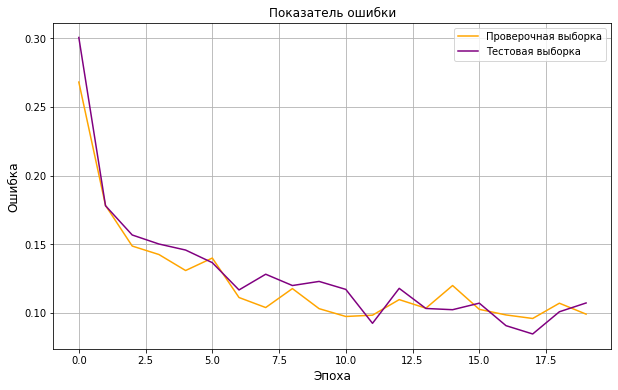

In [58]:
# график показатель ошибок для каждой эпохи
plt.figure(figsize=(10, 6))
plt.plot(hist_cars.history['loss'], color='orange', label='Проверочная выборка')
plt.plot(hist_2_cars.history['loss'], color='purple', label='Тестовая выборка')
plt.title('Показатель ошибки')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.legend()
plt.grid()
plt.show()

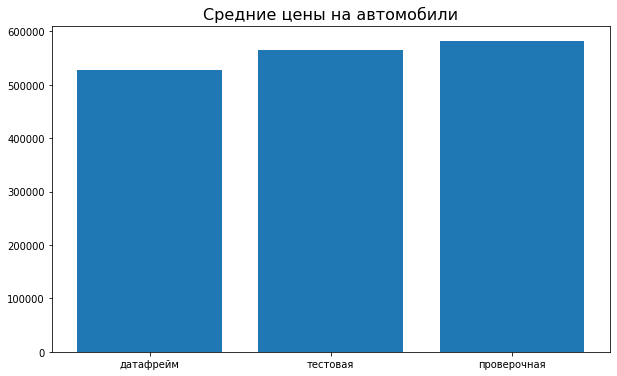

In [73]:
plt.figure(figsize=(10, 6))
#plt.subplot()
#plt.bar(np.mean(prediction_inverse))

x = np.arange(3)
height = [prices.mean(), np.mean(prediction_inverse_check), np.mean(prediction_inverse)]
plt.bar(x, height, align='center', linewidth=10)

plt.title('Средние цены на автомобили', fontsize=16)
plt.xticks(x, ['датафрейм', 'тестовая', 'проверочная'])
plt.show()